In [2]:
import os

os.chdir("..")

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\max-s\Desktop\Uni\Master\Masterthesis\Code\git\overparametrized_dnn


In [3]:
from data.regression_functions import m1, m2, m3, m4, m5, m6, m7, m8
from data.data_generator import get_data, preprocess
from src.my_dnn import create_dnn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import keras
import keras_tuner as kt

In [4]:
x, y = get_data(m8, x_dim=m8.expected_dim, num_samples=100)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

train_data = preprocess(x_train, y_train, training=True)
test_data = preprocess(x_test, y_test, training=False)

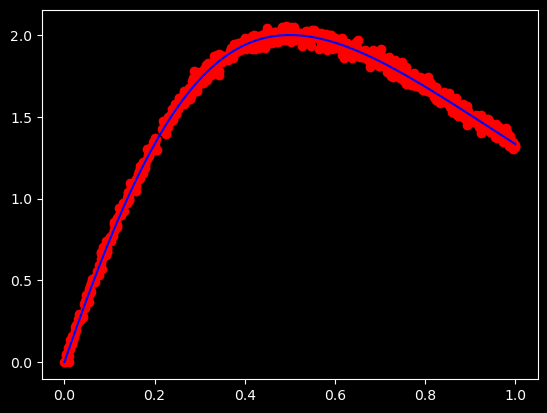

In [6]:
z = np.linspace(0, 1, 100)
h = m1(z)
plt.plot(z, h, label="m1", color="b")
plt.scatter(x_train, y_train, label="train data", color="r")
plt.show()

In [5]:
def build_hp_model(
            train_shape,
            num_networks,
            num_layers,
            num_neurons,
            beta,
            gamma,
            learning_rate
            ):
    
    model = create_dnn(
        train_shape=train_shape,
        num_networks=num_networks,
        num_layers=num_layers,
        num_neurons=num_neurons,
        beta=beta,
        gamma=gamma,
        delta=1,
    )

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer, 
        loss="mean_squared_error", 
        metrics=["mean_squared_error"]
        )
    return model

In [6]:
def build_hp_model(
            train_shape,
            num_networks,
            num_layers,
            num_neurons,
            beta,
            gamma,
            learning_rate
            ):
    
    model = create_dnn(
        train_shape=train_shape,
        num_networks=num_networks,
        num_layers=num_layers,
        num_neurons=num_neurons,
        beta=beta,
        gamma=gamma,
        delta=1,
    )

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer, 
        loss="mean_squared_error", 
        metrics=["mean_squared_error"]
        )
    return model

train_shape = x_train.shape

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_units = hp.Int('units', min_value=10, max_value=40, step=10)
        hp_layers = hp.Int('layers', min_value=5, max_value=20, step=5)
        hp_nets = hp.Int('networks', min_value=75, max_value=6*75, step=25)
        hp_beta = hp.Float('beta', min_value=20, max_value=80)
        hp_gamma = hp.Float('gamma', min_value=30, max_value=80)
        hp_learning_rate = hp.Float('learning_rate', min_value=np.exp(-16), max_value=np.exp(-14), sampling='log')
        
        model = build_hp_model(
            train_shape=train_shape,
            num_networks=hp_nets,
            num_layers=hp_layers,
            num_neurons=hp_units,
            beta=hp_beta,
            gamma=hp_gamma,
            learning_rate=hp_learning_rate
            )
        return model
    
# Initialize the tuner
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_loss',
    max_epochs=500,
    hyperband_iterations=4
)

# Note: Replace `x_train` and `y_train` with your actual training data and labels
# Start the hyperparameter search
tuner.search(x_train, y_train, epochs=100, validation_split=0.25)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(best_hps.values)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
20                |20                |units
20                |20                |layers
225               |225               |networks
31.009            |31.009            |beta
70.992            |70.992            |gamma
3.9013e-07        |3.9013e-07        |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3



In [8]:
# Initialize the tuner
tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_loss',
)

# Note: Replace `x_train` and `y_train` with your actual training data and labels
# Start the hyperparameter search
tuner.search(x_train, y_train, epochs=50, validation_split=0.25)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print(best_hps.values)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
30                |30                |units
5                 |5                 |layers
225               |225               |networks
73.374            |73.374            |beta
66.567            |66.567            |gamma
2.5894e-07        |2.5894e-07        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2



In [11]:
x_val, y_val = get_data(m1, x_dim=m1.expected_dim, num_samples=10**5)
validation_data = preprocess(x_val, y_val, training=False)

model.evaluate(validation_data)

1563/1563 [==============================] - 26s 17ms/step - loss: 0.0071 - mean_squared_error: 0.0071


[0.007052791304886341, 0.007052791304886341]

4/4 [==============================] - 0s 24ms/step


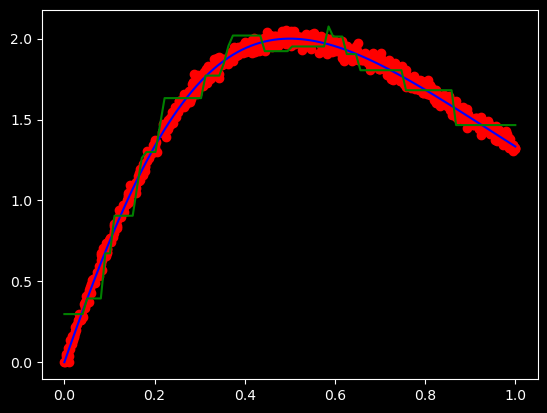

In [14]:
z = np.linspace(0, 1, 100)
h = m1(z)
h_pred = model.predict(z)
plt.plot(z, h, label="m1", color="b")
plt.plot(z, h_pred, label="m1_pred", color="g")
plt.scatter(x_train, y_train, label="train data", color="r")
plt.show()

In [15]:
import tensorflow as tf

def test_norm_l1(model):
    # Test if L1 projection of last layer worked
    weights = tf.reshape(model.trainable_variables[-1], [-1])
    norm = tf.norm(weights, ord=1)
    print("norm: {}, gamma: {}".format(norm, model.gamma))


def test_norm_l2(model):
    # Test if L2 projection of inner weights worked
    current_weights = tf.concat(
        [tf.reshape(v, [-1]) for v in model.trainable_weights[:-1]], axis=0
    )
    sub_nets_init_weights = model.sub_nets_init_weights
    diff = sub_nets_init_weights - current_weights
    norm = tf.norm(diff)
    print("norm: {}, delta: {}".format(norm, model.delta))

In [16]:
test_norm_l1(model)
test_norm_l2(model)

norm: 0.7622666954994202, gamma: 10
norm: 0.0030101335141807795, delta: 1.0
